## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Algoritm

In [3]:
import glob
import os
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import signal
import numpy as np
import scipy as sp
import scipy.io


def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def BandpassFilter(signal, fs=125):
    """
    Bandpass filter the signal between 40 and 240 BPM.
    """
        
    b, a = sp.signal.butter(5,(40/60, 240/60), btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)



def RunPulseRateAlgorithm(data_fl, ref_fl):
    fs = 125
    
    # Load ground truth heart rate
    ref_hr = sp.io.loadmat(ref_fl)['BPM0']
    
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    

    # Compute pulse rate estimates and estimation confidence.
    
    # Load PPG and Accelerometer Signals.  Get Freqs and FFT Spectra for PPG and Accelerometer signals.
    window_length_s = 8
    window_shift_s = 6
    nfft_window = fs*window_length_s
    noverlap = fs*window_shift_s
    
    # Bandpass signal between 40-240BPM.
    filt_ppg = BandpassFilter(ppg)
    filt_ppg_specs, filt_ppg_freqs,_,filt_ppg_im = plt.specgram(filt_ppg, NFFT = nfft_window, Fs=fs, noverlap=noverlap)
    plt.close()
    
    filt_accx = BandpassFilter(accx)
    accx_specs, accx_freqs,_,_ = plt.specgram(filt_accx, NFFT = nfft_window, Fs=fs, noverlap=noverlap)
    plt.close()
    
    filt_accy = BandpassFilter(accy)
    accy_specs, accy_freqs,_,_ = plt.specgram(filt_accy, NFFT = nfft_window, Fs=fs, noverlap=noverlap)
    plt.close()
    
    filt_accz = BandpassFilter(accz)
    accz_specs, accz_freqs,_,_ = plt.specgram(filt_accz, NFFT = nfft_window, Fs=fs, noverlap=noverlap)
    plt.close()
      
    
    ppg_max_freqs = []
    distance_bpm = 10
    distance_bps = distance_bpm/60
    count=0
    inner=0
    for i in range(filt_ppg_specs.shape[1]):
        accx_max_freq = accx_freqs[np.argmax(accx_specs[:,i])]
        accy_max_freq = accy_freqs[np.argmax(accy_specs[:,i])]
        accz_max_freq = accz_freqs[np.argmax(accz_specs[:,i])]
        sorted_ppg_specs = np.sort(filt_ppg_specs[:,i])[::-1]
        count += 1
        
        for f in range(10):
            ppg_freq = filt_ppg_freqs[np.argwhere(filt_ppg_specs == (sorted_ppg_specs[f]))[0][0]]
            inner+=1
            if ppg_freq == 0:
                continue
            elif (np.abs(ppg_freq-accx_max_freq)<=distance_bps) or (np.abs(ppg_freq-accy_max_freq)<=distance_bps) or (np.abs(ppg_freq-accz_max_freq)<=distance_bps):
                #if f == (filt_ppg_specs.shape[0]-1):
                if f == 9:
                    ppg_max_freqs.append(filt_ppg_freqs[np.argwhere(filt_ppg_specs == (sorted_ppg_specs[0]))[0][0]])
                continue
            else:
                ppg_max_freqs.append(ppg_freq)
                break        

    
    
    
    bpm_sum_window = 10
    bps_sum_window = bpm_sum_window/60
    
    ecgdata = sp.io.loadmat(ref_fl)['BPM0']
    
    confidences = []
    for i in range(filt_ppg_specs.shape[1]):
        low_window = ppg_max_freqs[i]-bps_sum_window 
        high_window = ppg_max_freqs[i] + bps_sum_window
        window = (filt_ppg_freqs>= low_window) & (filt_ppg_freqs<=high_window)
        confidence=np.sum(filt_ppg_specs[:,i][window])/np.sum(filt_ppg_specs[:,i])
        error = np.abs(ppg_max_freqs[i]*60-ecgdata[i][0])
        confidences.append((i, ppg_max_freqs[i]*60, ecgdata[i][0], confidence, error))

    confidence_df = pd.DataFrame(
                    data=confidences, 
                    columns=['WindowNumber','Estimated_Pulse_Rate','Ref_BPM','Confidence','Error'])
    
  
    errors = confidence_df['Error'].values
    confidence = confidence_df['Confidence'].values
    
    return errors, confidence

In [4]:
Evaluate()

11.9595298802115

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - This algorithm estimates the pulse rate from the PPG signal measurements and contemporaneous measurements from a 3-axis accelerometer. The pulse rate is restricted between 40BPM (beats per minute) and 240BPM. The output is an estimation confidence.
Input:
It takes in .mat file format.

> - **Data Description** - Troika dataset was used to build this algorithm.
>   - Data acquisition: Data were acquired from sensors during various activities such as rest, jog, and run at various speeds.
>   - Features of sensor: ECG sensor generated signal with one channel while PPG sensor generated two signals from each wrist and the accelerometer generated signals with three channels (x, y and z).
>   - Limitation: Data for use to build this algorithm were recorded on fixed actions.

> - **Algorithhm Description** 
This algorithm gather information from Photoplethysmography (PPG) sensors worn on wrist. The PPG sensors measure the the amont of light absorbed by red blood cells in the capilaries arround the wrist. When heart contract blood are pumped to the wriest and other extremitiess, them more light is absorbed by PPG. On the other hand when heart relax, there is decrease in amount of blood in the wrist and other extremities, lesser light is absorbed. 
In addition, activities such as arm motions cause blood movement through the wrist. This type of periodical movement needs to be diffrerntiated from pulse rate. It is important that pulse rate estimator is able to distinguish this periodic signal from the pulse rate. I used the accelerometer signal to measure periodical signal caused by movement. 

> - **Algorithm Performance** - With the training dataset, the Evaluate() command shows that the error is 11.9595. With the test dataset, the error is 7.55.

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria.
![](test.png)


### Exploratory Data Analysis

In [6]:
data_fls, ref_fls = LoadTroikaDataset()
data_fls, ref_fls

(['./datasets/troika/training_data/DATA_01_TYPE01.mat',
  './datasets/troika/training_data/DATA_02_TYPE02.mat',
  './datasets/troika/training_data/DATA_03_TYPE02.mat',
  './datasets/troika/training_data/DATA_04_TYPE01.mat',
  './datasets/troika/training_data/DATA_04_TYPE02.mat',
  './datasets/troika/training_data/DATA_05_TYPE02.mat',
  './datasets/troika/training_data/DATA_06_TYPE02.mat',
  './datasets/troika/training_data/DATA_07_TYPE02.mat',
  './datasets/troika/training_data/DATA_08_TYPE02.mat',
  './datasets/troika/training_data/DATA_10_TYPE02.mat',
  './datasets/troika/training_data/DATA_11_TYPE02.mat',
  './datasets/troika/training_data/DATA_12_TYPE02.mat'],
 ['./datasets/troika/training_data/REF_01_TYPE01.mat',
  './datasets/troika/training_data/REF_02_TYPE02.mat',
  './datasets/troika/training_data/REF_03_TYPE02.mat',
  './datasets/troika/training_data/REF_04_TYPE01.mat',
  './datasets/troika/training_data/REF_04_TYPE02.mat',
  './datasets/troika/training_data/REF_05_TYPE02.mat

In [7]:
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])
ppg, accx, accy, accz

(array([   4. ,    6. ,    3. , ...,   86. ,  104. ,  118.5]),
 array([-0.0702, -0.0702, -0.0546, ...,  0.4134,  0.4134,  0.4134]),
 array([ 0.3432,  0.3588,  0.3666, ..., -0.2808, -0.273 , -0.273 ]),
 array([ 0.9594,  0.9438,  0.936 , ...,  0.7254,  0.7176,  0.7254]))

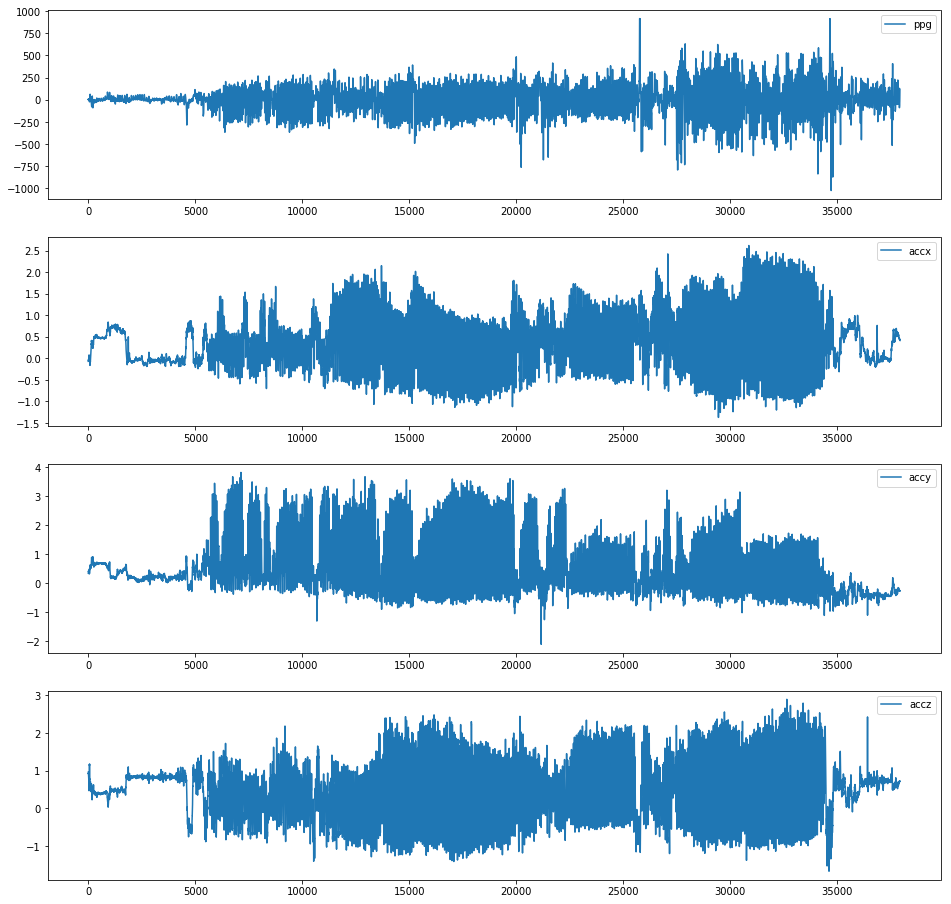

In [8]:
data_list = [ppg, accx, accy, accz]
label_list = ['ppg', 'accx', 'accy', 'accz']

figs, axes = plt.subplots(4, figsize=(16, 16))
for i, ax in enumerate(axes):
    axes[i].plot(data_list[i], label = label_list[i])
    axes[i].legend(loc='upper right')